In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL
import json
from urbanComponent import *
import math

from persim import plot_diagrams
from ripser import ripser, lower_star_img

In [2]:
f = open('../../../public/data/manhattan_wo_cells/buildings_s_joined.json', 'r')

data = json.load(f)

joinedLayerIndex = 0

values = []

for joinedObject in data['joinedObjects']:
    if(joinedObject['joinedLayerIndex'] == joinedLayerIndex):
        values = joinedObject['otherValues']
        break

f.close()

uc = UrbanComponent()

uc.setWorkDir("../../../public/data/manhattan_wo_cells")
uc.addLayerFromJsonFile("../../../public/data/manhattan_wo_cells/buildings_s.json")

buildingsJson = uc.layers['json'][0]

# f = open('./buildings.json', 'w')

# f.write(json.dumps(buildingsJson))

# f.close()

latitude = []
longitude = []
height = []

for geometry in buildingsJson['data']:
    for i in range(int(len(geometry['geometry']['coordinates'])/3)):
        latitude.append(geometry['geometry']['coordinates'][i*3])
        longitude.append(geometry['geometry']['coordinates'][i*3+1])
        height.append(geometry['geometry']['coordinates'][i*3+2])

df = pd.DataFrame(data={'latitude': latitude, 'longitude': longitude, 'height': height})

m1 = df[['latitude','longitude','height']].to_numpy()[:,1]
m2 = df[['latitude','longitude','height']].to_numpy()[:,0]
m3 = df[['latitude','longitude','height']].to_numpy()[:,2]

xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
zmin = m3.min()
zmax = m3.max()

values = np.array(values).reshape((len(values),))

wmin = values.min()
wmax = values.max()

X, Y, Z, W = np.mgrid[xmin:xmax:100, ymin:ymax:100, zmin:zmax:50, wmin:wmax:0.1]

positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel(), W.ravel()]) # grid positions

data_points = np.vstack([m1, m2, m3, values]) 

kernel = scipy.stats.gaussian_kde(data_points)

sampled_values = np.reshape(kernel(positions).T, X.shape)


In [21]:
X.min()

4940393.3058

In [23]:
X.max() - X.min()

1500.0

In [4]:
# for row in sampled_values:
#     for column in row:
#         for value in column:
#             if(value > 0.5):
#                 print(value)

In [5]:
# fig, ax = plt.subplots()
# ax.imshow(np.rot90(sampled_values), cmap=plt.cm.YlOrBr, extent=[xmin, xmax, ymin, ymax])
# ax.set_xlim([xmin, xmax])
# ax.set_ylim([ymin, ymax])
# plt.show()

C:\Users\Gustavo\AppData\Local\Temp\ipykernel_25072\2120929520.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  gaussian_weights = np.array([2, 1], dtype=np.float)
C:\Users\Gustavo\AppData\Local\Temp\ipykernel_25072\2120929520.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  weights = np.array(weights, np.float)


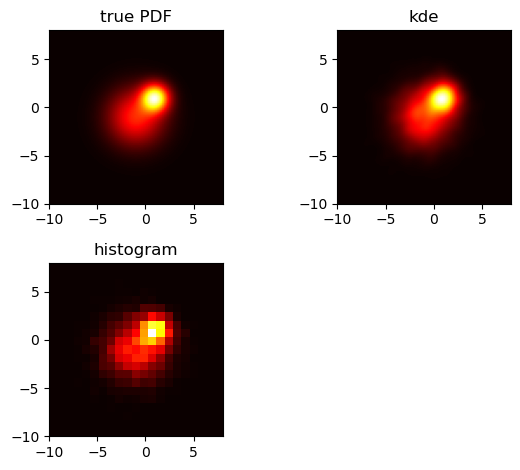

In [6]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

bins = 21

#Define a Gaussian mixture to draw samples from
num_samples = 10000
xmin, xmax = -10, 8
#Weight attributed to each component of the mixture
gaussian_weights = np.array([2, 1], dtype=np.float)
gaussian_weights /= np.sum(gaussian_weights)
#Mean and std of each mixture
gaussian_means = np.array([-1, 1])
gaussian_std = np.array([2, 1])
#Observation probability of each mixture
gaussian_observation = np.array([1, .5])

#How many samples belong to each mixture?
gaussian_samples = np.random.multinomial(num_samples, gaussian_weights)
samples = []
weights = []
#Generate samples and observed samples for each mixture component
for n, m, s, o in zip(gaussian_samples, gaussian_means, gaussian_std, gaussian_observation):
    _samples = np.random.normal(m, s, (n, 2))
    _samples = _samples[o > np.random.uniform(size=n)]
    samples.extend(_samples)
    weights.extend(np.ones(len(_samples)) / o)

#Renormalise the sample weights
weights = np.array(weights, np.float)
weights /= np.sum(weights)
samples = np.transpose(samples)

#Evaluate the true pdf on a grid
x = np.linspace(xmin, xmax, 100)
xx, yy = np.meshgrid(x, x)
true_pdf = 0
for w, m, s in zip(gaussian_weights, gaussian_means, gaussian_std):
    true_pdf = true_pdf + w * stats.norm(m, s).pdf(xx) * stats.norm(m, s).pdf(yy)

#Evaluate the kde on a grid
pdf = stats.gaussian_kde(samples, weights=weights)
zz = pdf((np.ravel(xx), np.ravel(yy)))
zz = np.reshape(zz, xx.shape)

kwargs = dict(extent=(xmin, xmax, xmin, xmax), cmap='hot', origin='lower')
#Plot the true pdf
plt.subplot(221)
plt.imshow(true_pdf.T, **kwargs)
plt.title('true PDF')

#Plot the kde
plt.subplot(222)
plt.imshow(zz.T, **kwargs)
plt.title('kde')
plt.tight_layout()

#Plot a histogram
ax = plt.subplot(223)
plt.hist2d(samples[0], samples[1], bins, ((xmin, xmax), (xmin, xmax)), 
           True, weights, cmap='hot')
ax.set_aspect(1)
plt.title('histogram')
plt.tight_layout()
plt.show()